In [337]:
# Load libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Turn off warnings to reduce angry red-space in notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Identify city and date range of interest (same as used within Twitter scrape)

In [338]:
city = 'Manila'
start_date = dt.date(2014, 1, 1)
end_date = dt.date(2018, 1, 1)

In [339]:
# Read .csv created with above parameters
df = pd.read_csv(f'../data/tweetscrape_{city}_{start_date}_to_{end_date}.csv')

In [340]:
# Create df with only columns of interest
tweets = df[['username', 'tweet_id', 'timestamp', 'timestamp_epochs', 'retweets', 'text']]

In [341]:
tweets.shape

(702, 6)

In [342]:
tweets['timestamp'].dtypes

dtype('O')

### Manipulate timestamp

#### Remove seconds and convert to date-time

In [343]:
# loop through rows to change timestamp format into something functional:

date_list = []

for tweet in tweets['timestamp']:
    tweet = tweet.replace(' ', '')[:-8]
    date_list.append(tweet)
    
tweets['clean_date'] = date_list
tweets['clean_date']

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0      2017-03-10
1      2017-02-22
2      2017-02-12
3      2016-12-24
4      2016-12-24
          ...    
697    2014-06-09
698    2014-06-05
699    2014-06-05
700    2014-06-04
701    2014-05-31
Name: clean_date, Length: 702, dtype: object

In [344]:
tweets

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
0,aaronrecuenco,840133530529161218,2017-03-10 09:33:37,1489138417,0,Two kids die of electrocution in floodwaters o...,2017-03-10
1,LittleMaviLearn,834248603971391488,2017-02-22 03:49:01,1487735341,0,Hundreds rescued from California floodwaters i...,2017-02-22
2,Naskoivanov72,830571439396888576,2017-02-12 00:17:17,1486858637,0,Filipino boys play basketball in floodwaters f...,2017-02-12
3,foreca,812637994729566208,2016-12-24 12:36:10,1482582970,1,Typhoon Nock-ten crosses through the northern ...,2016-12-24
4,johnnyhosg,812623093336150017,2016-12-24 11:36:57,1482579417,0,https://plus.google.com/115160545770949042069/...,2016-12-24
...,...,...,...,...,...,...,...
697,WB_AsiaPacific,475872431199223808,2014-06-09 05:30:03,1402291803,1,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-09
698,WB_AsiaPacific,474611742832877568,2014-06-05 18:00:32,1401991232,0,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-05
699,WB_AsiaPacific,474422878499536896,2014-06-05 05:30:03,1401946203,2,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-05
700,WB_AsiaPacific,474061762976051200,2014-06-04 05:35:06,1401860106,2,#Philippines: M. Manila #Flood Risk Management...,2014-06-04


In [345]:
tweets['clean_date'] = pd.to_datetime(tweets['clean_date'], format='%Y-%m-%d')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [346]:
tweets.dtypes

username                    object
tweet_id                     int64
timestamp                   object
timestamp_epochs             int64
retweets                     int64
text                        object
clean_date          datetime64[ns]
dtype: object

#### Convert original timestamp to datetime

In [347]:
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [348]:
# Identify # of unique cells in this column
tweets['timestamp'].nunique()

530

In [349]:
df.shape[0]

702

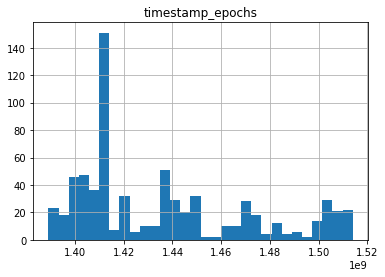

In [350]:
tweets.hist(column = 'timestamp_epochs', bins = 30);

In [351]:
tweets.describe()

,tweet_id,timestamp_epochs,retweets
count,7.020000e+02,7.020000e+02,702.000000
mean,6.183217e+17,1.436254e+09,0.988604
std,1.508104e+17,3.595600e+07,7.882329
min,4.204171e+17,1.389070e+09,0.000000
25%,5.127474e+17,1.411083e+09,0.000000
50%,5.504848e+17,1.420081e+09,0.000000
75%,7.250259e+17,1.461695e+09,0.000000
max,9.446527e+17,1.514058e+09,187.000000


In [352]:
tweets[tweets['retweets'] > 500]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date


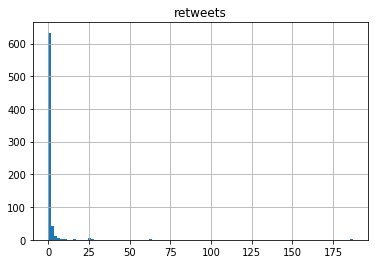

In [353]:
tweets.hist(column = 'retweets', bins = 100);

In [354]:
# Identify duplicate tweet content (identical shared newsitems, users with multiple twitter accounts, etc)
tweets[tweets.duplicated(['text'])]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
11,aaronrecuenco,840133530529161218,2017-03-10 09:33:37,1489138417,0,Two kids die of electrocution in floodwaters o...,2017-03-10
12,LittleMaviLearn,834248603971391488,2017-02-22 03:49:01,1487735341,0,Hundreds rescued from California floodwaters i...,2017-02-22
13,Naskoivanov72,830571439396888576,2017-02-12 00:17:17,1486858637,0,Filipino boys play basketball in floodwaters f...,2017-02-12
14,foreca,812637994729566208,2016-12-24 12:36:10,1482582970,1,Typhoon Nock-ten crosses through the northern ...,2016-12-24
15,johnnyhosg,812623093336150017,2016-12-24 11:36:57,1482579417,0,https://plus.google.com/115160545770949042069/...,2016-12-24
...,...,...,...,...,...,...,...
506,lyndajumilla,518001492754591745,2014-10-03 11:35:54,1412336154,4,"Heavy rain, no let-up, for 20 minutes now in m...",2014-10-03
557,christian_aid,513009690864021504,2014-09-19 17:00:16,1411146016,3,Metro #Manila & surrounding areas are under wa...,2014-09-19
697,WB_AsiaPacific,475872431199223808,2014-06-09 05:30:03,1402291803,1,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-09
698,WB_AsiaPacific,474611742832877568,2014-06-05 18:00:32,1401991232,0,#Philippines: Metro Manila #Flood Risk Managem...,2014-06-05


In [355]:
tweets = tweets.drop_duplicates(['text'])

In [356]:
tweets.shape

(522, 7)

In [357]:
tweet_count_month = tweets.groupby([tweets["clean_date"].dt.year, tweets["clean_date"].dt.month])[['text']].count()

In [358]:
# Thus our clean_date becomes the index for our data...
daily_tweets = tweets.groupby(tweets['clean_date'])[['text']].count()

In [359]:
tweet_count_month

text
clean_date clean_date      
2014       1             16
           2              9
           3             13
           4              7
           5             21
           6             23
           7             29
           8             28
           9             90
           10            41
           11             1
           12            13
2015       1              6
           2              3
           3              1
           4              2
           5             12
           6              8
           7             27
           8             14
           9             18
           10            11
           11             2
           12            15
2016       2              2
           4              2
           5              2
           6              2
           7             10
           8             16
           9              5
           10             3
           11             2
           12             6
2017       2              2
           3              2
           4              1
           5              1
           6              1
           7              6
           8             13
           9             22
           10             3
           12            11

In [360]:
tweets['year'] = tweets['clean_date'].dt.year
tweets['month'] = tweets['clean_date'].dt.month

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [361]:
test = tweets.groupby([tweets["year"], tweets["month"]])[['text']].count()

In [362]:
test.reset_index()

,year,month,text
0,2014,1,16
1,2014,2,9
2,2014,3,13
3,2014,4,7
4,2014,5,21
5,2014,6,23
6,2014,7,29
7,2014,8,28
8,2014,9,90
9,2014,10,41


In [363]:
tweet_count_month[:][1:3]

text
clean_date clean_date      
2014       2              9
           3             13

### Set Timestamp to Index for TimeSeries

In [364]:
tweets.index.type

AttributeError: 'Int64Index' object has no attribute 'type'

In [ ]:
tweets.set_index('timestamp', inplace = True)
tweets.sort_index(inplace = True)

(array([43.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.00000e+00, 1.50660e+03, 3.01220e+03, 4.51780e+03, 6.02340e+03,
        7.52900e+03, 9.03460e+03, 1.05402e+04, 1.20458e+04, 1.35514e+04,
        1.50570e+04]),
 <a list of 10 Patch objects>)

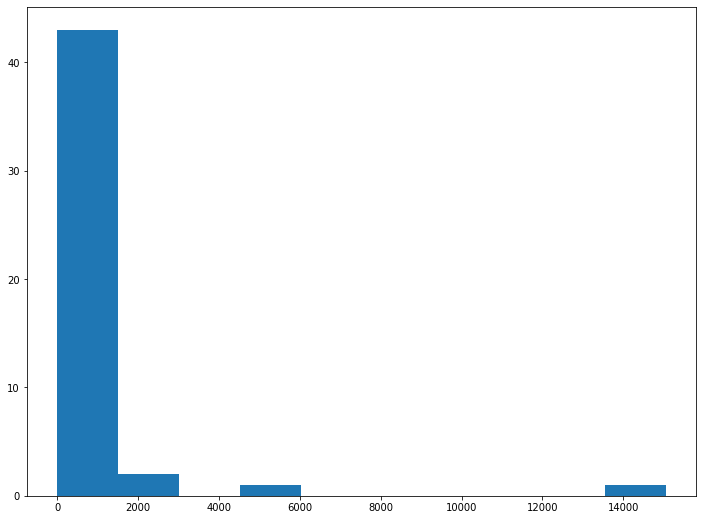

In [27]:
fig, ax = plt.subplots(figsize = (12, 9))

ax.hist(tweet_count_month)

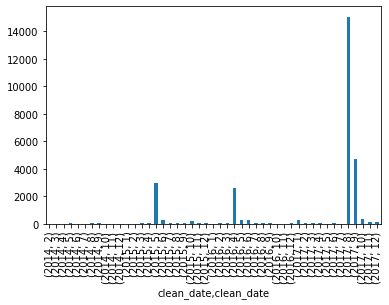

In [28]:
tweets['text'].groupby([tweets["clean_date"].dt.year, tweets["clean_date"].dt.month]).count().plot(kind="bar");

In [365]:
daily_tweets.resample('W').count()

,text
clean_date,
2014-01-12,4
2014-01-19,5
2014-01-26,2
2014-02-02,2
2014-02-09,1
...,...
2017-11-26,0
2017-12-03,0
2017-12-10,0


AttributeError: 'AxesSubplot' object has no attribute 'use'

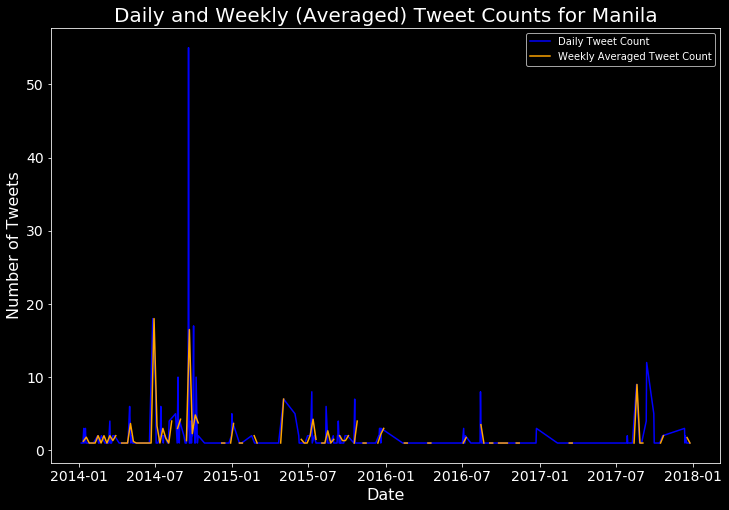

In [401]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Weekly Averaged Tweet Count']);
ax.set_title(f'Daily and Weekly (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.use('dark_background')
plt.savefig(f'../figs/dailyct_and_monthlyavg_tweets_{city}.png')

AttributeError: 'AxesSubplot' object has no attribute 'use'

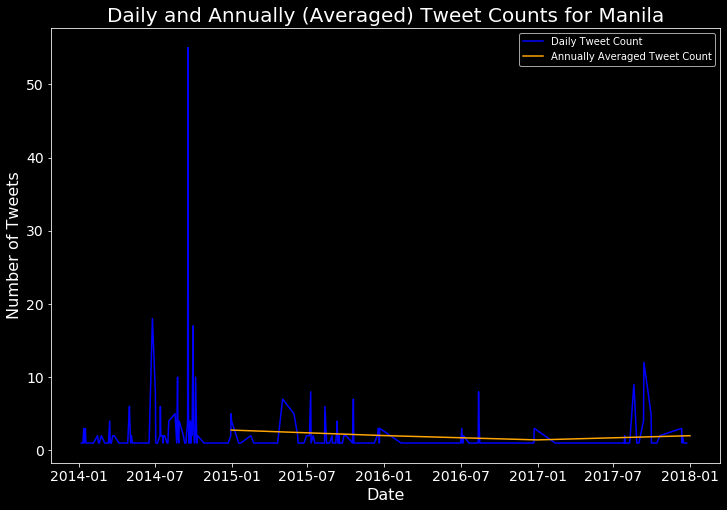

In [402]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('A').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Annually Averaged Tweet Count']);
ax.set_title(f'Daily and Annually (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.use('dark_background')
plt.savefig(f'../figs/dailyct_and_annavg_tweets_{city}.png')

In [125]:
daily_tweets

,text
clean_date,
2014-02-13,1
2014-02-22,1
2014-03-18,1
2014-03-28,1
2014-04-28,1
...,...
2017-12-27,2
2017-12-28,4
2017-12-29,3


In [372]:
# Overall average can be skewed by an anomalous year
daily_tweets['text'].mean()

2.2695652173913046

In [373]:
# Get annual averaged numbers of tweets instead
mean_ann_tweets = daily_tweets[['text']].resample('A').mean()

In [379]:
mean_ann_tweets.index = mean_ann_tweets.index.year

In [380]:
daily_tweets

,text
clean_date,
2014-01-07,1
2014-01-09,1
2014-01-11,1
2014-01-12,2
2014-01-13,3
...,...
2017-12-16,1
2017-12-19,1
2017-12-20,1


In [381]:
mean_ann_tweets

,text
clean_date,
2014,2.771429
2015,2.016949
2016,1.428571
2017,2.000000


In [382]:
# Identify all days with tweet counts greater than their respective annual average
bool_list = []
for i in range(len(daily_tweets)):
    bool_list.append(daily_tweets['text'][i] >= mean_ann_tweets.loc[daily_tweets.index[0].year,'text'])
daily_tweets['above_avg'] = bool_list

In [383]:
daily_tweets[daily_tweets['above_avg']==True]

,text,above_avg
clean_date,,
2014-01-13,3,True
2014-01-17,3,True
2014-03-16,4,True
2014-05-02,6,True
2014-05-03,4,True
2014-06-26,18,True
2014-07-03,8,True
2014-07-15,6,True
2014-08-04,4,True


In [384]:
# Create new dataframe just for days with above average tweet counts
above_avg_tweets = daily_tweets.loc[daily_tweets['above_avg'] == True].drop(columns = 'above_avg')

In [385]:
(above_avg_tweets.resample('W').sum())['text']

clean_date
2014-01-19    6
2014-01-26    0
2014-02-02    0
2014-02-09    0
2014-02-16    0
             ..
2017-11-19    0
2017-11-26    0
2017-12-03    0
2017-12-10    0
2017-12-17    3
Freq: W-SUN, Name: text, Length: 205, dtype: int64

In [386]:
above_avg_tweets

,text
clean_date,
2014-01-13,3
2014-01-17,3
2014-03-16,4
2014-05-02,6
2014-05-03,4
2014-06-26,18
2014-07-03,8
2014-07-15,6
2014-08-04,4


In [387]:

daily_tweets[daily_tweets['text'] > daily_tweets['text'].mean()]

,text,above_avg
clean_date,,
2014-01-13,3,True
2014-01-17,3,True
2014-03-16,4,True
2014-05-02,6,True
2014-05-03,4,True
2014-06-26,18,True
2014-07-03,8,True
2014-07-15,6,True
2014-08-04,4,True


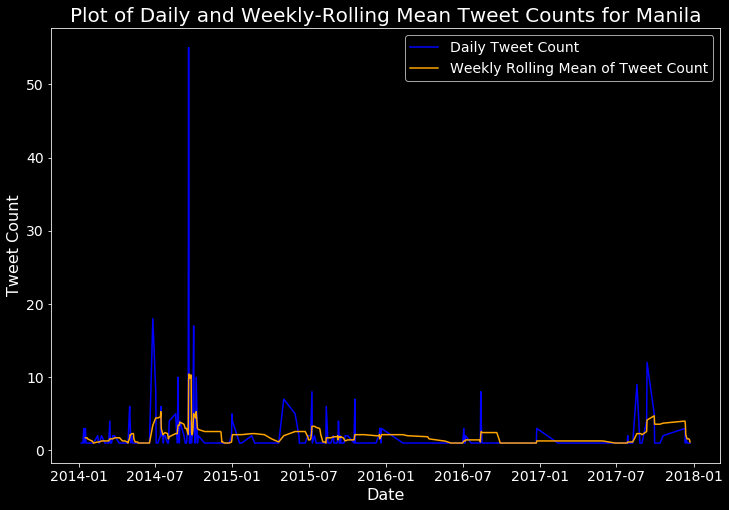

In [404]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], label = 'Daily Tweet Count', color = 'blue');
ax.plot(daily_tweets['text'].rolling(7).mean(), label = 'Weekly Rolling Mean of Tweet Count', color = 'orange');
ax.set_title(f'Plot of Daily and Weekly-Rolling Mean Tweet Counts for {city}', fontsize = 20);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Tweet Count', fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize = 14)
plt.savefig(f'../figs/daily_weeklyrollingmean_{city}.png')


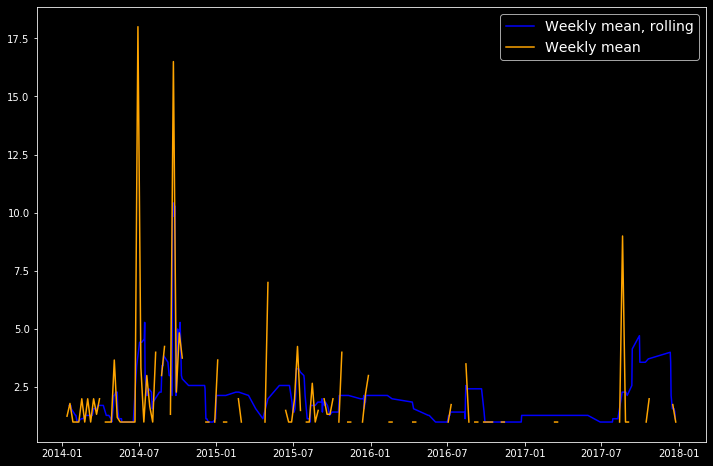

In [405]:
plt.figure(figsize = (12, 8))
plt.plot(daily_tweets['text'].rolling(7).mean(), color = 'blue');
plt.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
plt.legend(['Weekly mean, rolling', 'Weekly mean'], fontsize = 14);

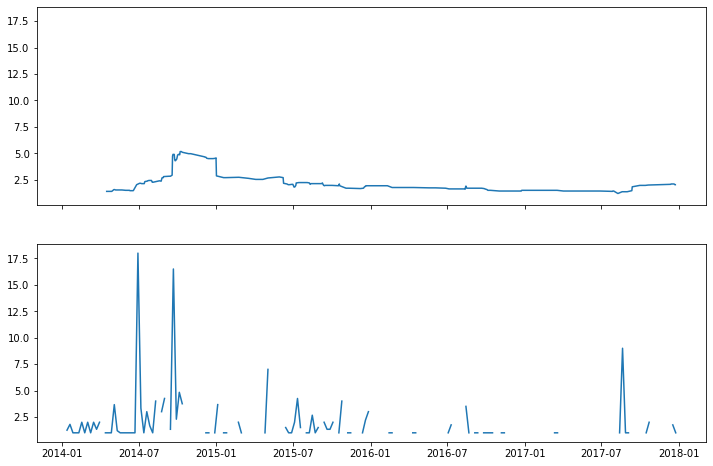

In [392]:
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8), sharex = True, sharey = True)

ax[0].plot(daily_tweets['text'].rolling(30).mean());
ax[1].plot(daily_tweets['text'].resample('W').mean());

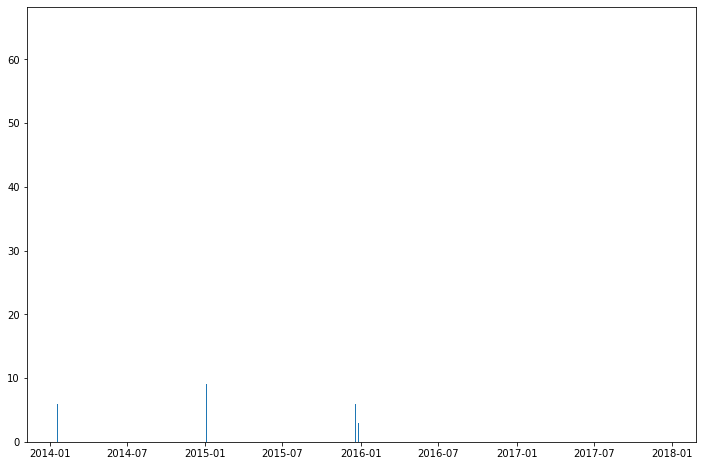

In [393]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].resample('W').sum().index, above_avg_tweets['text'].resample('W').sum());

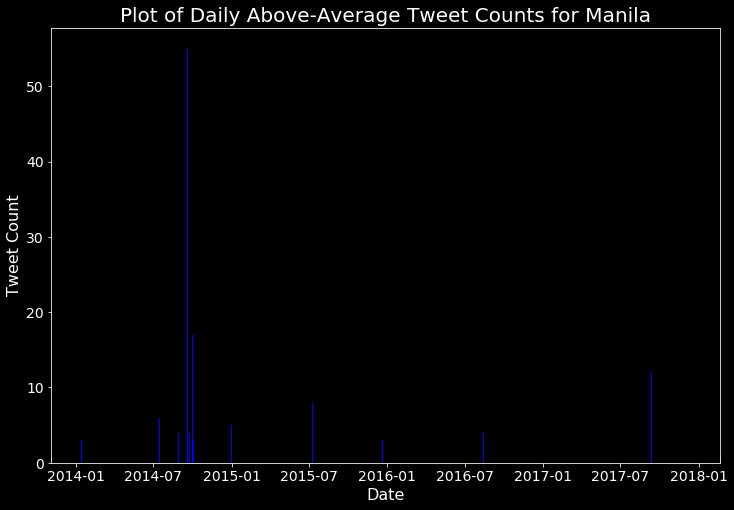

In [406]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].index, above_avg_tweets['text'], color = 'blue');
plt.title(f'Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Tweet Count', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/daily_abvavg_{city}.png')

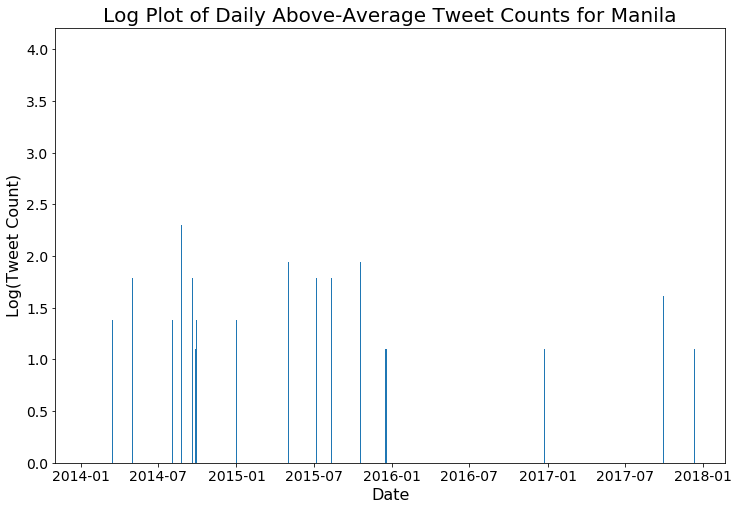

In [395]:
plt.figure(figsize = (12, 8));
plt.bar(above_avg_tweets['text'].index, np.log(above_avg_tweets['text']));
plt.title(f'Log Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Log(Tweet Count)', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/log_daily_abvavg_{city}.png')

### CountVectorizer & Show Most Frequent Words

In [144]:
cvec_tw = CountVectorizer()

In [157]:
stopWords = ['com', 'http', 'twitter', 'https', 'pic', 'www', 'ly', 
             'yahoo', 'yhoo', 'youtu', 'youtube', 'fb', 'instagram', 
             'tt', 'html'] + list(ENGLISH_STOP_WORDS) 

In [159]:
# Initiate instance of CountVectorizer for tweet data
cvec_tw = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'title' column from climatechange data
X_tw = tweets['text']

# Fit the vectorizer to our corpus
cvec_tw.fit(X_tw)

# Transform the training corpus
X_tw = cvec_tw.transform(X_tw)

# Convert result into a dataframe
X_tw_df = pd.DataFrame(X_tw.toarray(),
                          columns=cvec_tw.get_feature_names())
X_tw_df.head()

,000,01,04,05,08,09,10,11,12,12145510,...,weight,west,woman,work,world,wow,wp,ws,year,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [160]:
X_tw_df.shape

(28139, 500)

In [166]:
# Save 20 most frequently appearing words to a df, in descending order
tw_bardat = X_tw_df.sum().sort_values(ascending = False)[0:20].to_frame()

In [167]:
tw_bardat.index

Index(['houston', 'floodwaters', 'harvey', 'flooding', 'flood', 'texas',
       'news', 'status', 'police', 'houstonflood', 'hurricane', '2017',
       'floodwater', 'officer', 'rain', 'rising', 'rescue', 'hurricaneharvey',
       'rise', 'bit'],
      dtype='object')

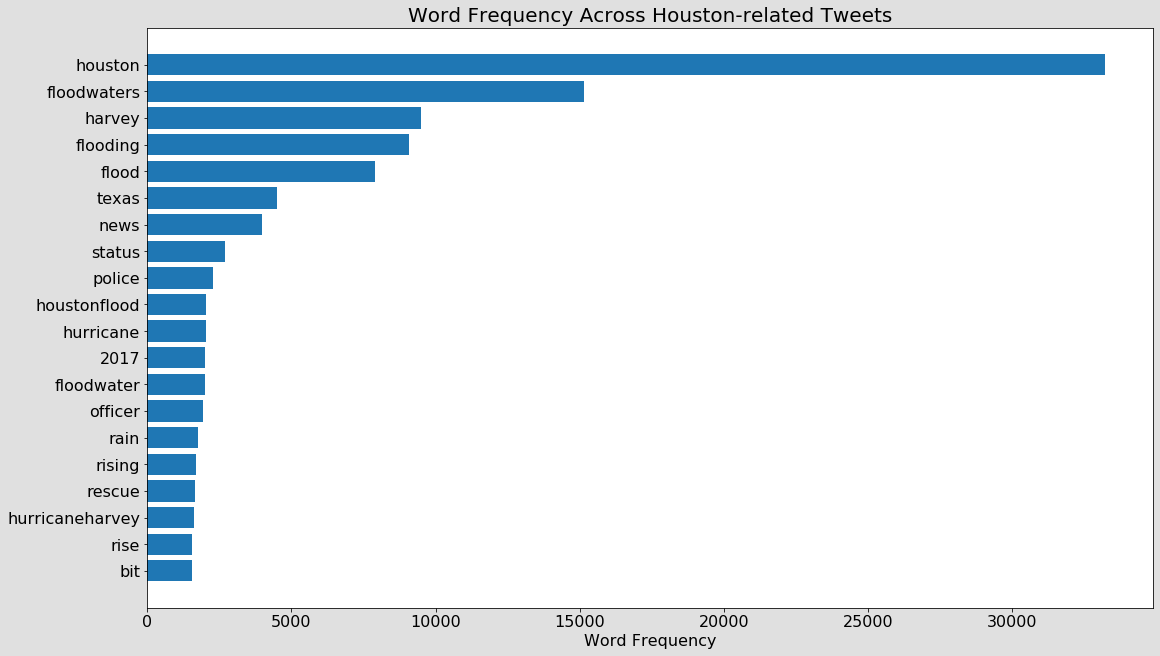

In [168]:
fig, ax = plt.subplots(figsize=(16, 9), sharex = True, constrained_layout = True, # Share x axes to keep ranges the same
                              facecolor = '#E0E0E0')  # Set figure facecolor to match slide theme
ax.barh(tw_bardat.index, tw_bardat[0]);
ax.invert_yaxis(); # Flip plot vertically so values descending from top
ax.set_title(f'Word Frequency Across {city}-related Tweets', fontsize = 20);
ax.set_xlabel('Word Frequency', fontsize = 16);
ax.set_yticklabels(tw_bardat.index, fontsize = 14)
ax.tick_params(labelsize = 16)
         

In [ ]:
# For loop to do most of my 'Title' cleaning--remove punctuation, convert to lowercase, lemmatize
# With guidance from Preeya Sawadmanod

text_puncless = []
text_lemmed = []

for row in tweets['text']:
    # Instantiate tokenizer/set to remove punctuation, numbers, and any 'words' comprised of just 1 character
    # Numbers removed because many were completely extraneous
    # And the ones that might have been useful weren't useful enough to justify keeping the rest
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # (r'\w+')

    # Instantiate lemmatizer: lemmatizer over stemmer because false negatives are preferable here to false positives
    # We don't want to over-estimate the accuracy of our predictions
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize each row (also do the change to lower-case here)
    rows = tokenizer.tokenize(row.lower())
    
    # Lemmatize all words in each row
    lem_rows = [lemmatizer.lemmatize(word) for word in rows]
    
    # Change each row back from a list of strings to a single string
    rows = ' '.join(rows)
    lem_rows = ' '.join(lem_rows)
    
    # Append fixed rows to their respective lists
    text_puncless.append(rows)
    text_lemmed.append(lem_rows)

In [ ]:
len(text_puncless)

In [ ]:
tweets.shape

In [ ]:
# Insert cleaned lists of titles into dataframe as new columns
tweets['text_nopunc'] = text_puncless
tweets['text_lemmed'] = text_lemmed

In [ ]:
tweets.head()

In [ ]:
# WORD-TO-VEC ???? Try kmeans with and without word2vec
# Support vector machines
# KMeans
# Cosine similarity?


In [ ]:
X = tweets['text_lemmed']


### KMeans clustering with CountVectorizer

In [ ]:
cvec_X = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'title' column from climatechange data
X_cvec = X

# Fit the vectorizer to our corpus
cvec_X.fit(X_cvec)

# Transform the training corpus
X_cvec = cvec_X.transform(X_cvec)

# Convert result into a dataframe
X_cvec_df = pd.DataFrame(X_cvec.toarray(),
                          columns=cvec_X.get_feature_names())
X_cvec_df.head()

In [ ]:
Xcols = list(X_cvec_df.columns)

In [ ]:
km = KMeans(n_clusters = 5, random_state = 42)
sc = StandardScaler()
X_sc = sc.fit_transform(X_cvec_df[Xcols])

In [ ]:
km.fit(X_sc)

In [ ]:
km.cluster_centers_

In [ ]:
tweets["cluster"] = km.labels_
tweets.tail()

In [ ]:
tweets.groupby(['cluster']).count()

In [ ]:
plt.figure(figsize=(7,7));

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue"]
tweets['color'] = tweets['cluster'].map(lambda p: colors[p])

### Kmeans Clustering with TFIDF

In [ ]:
# Fit the transformer.
tvec_X = TfidfVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

In [ ]:
tvec_X

In [ ]:
# Pull out 'title' column from climatechange data
X_tvec = X

# Fit the vectorizer to our corpus
tvec_X.fit(X_tvec)

# Transform the training corpus
X_tvec = tvec_X.transform(X_tvec)

# Convert result into a dataframe
X_tvec_df = pd.DataFrame(X_tvec.toarray(),
                          columns=tvec_X.get_feature_names())
X_tvec_df.head()

In [ ]:
X_tvec[100:102,:]

In [ ]:
Xcols = list(X_tvec_df.columns)

In [ ]:
km = KMeans(n_clusters = 5, random_state = 86753)
sc = StandardScaler()
X_sc = sc.fit_transform(X_tvec_df[Xcols])

In [ ]:
km.fit(X_tvec)

In [ ]:
km.n_iter_

In [ ]:
km.cluster_centers_

In [ ]:
tweets["cluster"] = km.labels_
tweets.tail()

In [ ]:
tweets.groupby(['cluster']).count()

In [ ]:
silhouette_score(X_sc, km.labels_)

In [ ]:
km.inertia_

In [ ]:
# Now testing a varying k
scores = []
for k in range(2, 31):
    km = KMeans(k, random_state=1234)
    km.fit(X_tvec)
    inertia = km.inertia_
    sil = silhouette_score(X_tvec, km.labels_)
    scores.append((k, inertia, sil))

In [ ]:
score_df = pd.DataFrame(scores, columns=["k", "inertia", "sil"])
score_df.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7));
axes[0].plot(score_df.k, score_df.inertia);
axes[0].set_title('Inertia over k');
axes[1].plot(score_df.k, score_df.sil);
axes[1].set_title('Silhouette Score over k');

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('km', KMeans())
])

In [ ]:
pipe_params = {
    'cvec__max_features': [500],
    'cvec__min_df': [2],
    'cvec__max_df': [0.98],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [stopWords],
    'km__n_clusters': [3, 5],
    'km__random_state': [42]
}

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.

In [ ]:
gs.fit(X)

In [ ]:
gs.cluster_centers_